This mock data uses a fixed global parameter + random draws for the age and theta parameters.

13) MOCK DATASETS (don't use the AM207 ones):

    a) Use some ISM parameters that represent different components of the ISM e.g. leave ISM parameters at their prior values and each time vary one by 2 sigma. one bursty SFR environment (SFR - 2sigma), one leaky (x_out + 2), one low SFE environment. And then see how well you can retrieve those. You will also see, that the ISM parameters are correlated (the signal will be redistributed into ather ISM parameters). I suggest it this way because in a paper you can plot the different tracks, name them (bursty, leaky etc) and plot the mock star abundances at specific times. And then you can show how well you can retrieve them. Of course you will have to add observational uncertainties to your predicted abundances. You can test with very low observational uncertainties, but a fair test would be to use typical observational uncertainties. This doesn't need any error parameters per element.
    
    b) In a last step you will need to do the inference with a wrong yield set as well (only then the error parameters per element will also be needed).



In [1]:
%pylab inline
import os
os.chdir('/home/oliverphilcox/ChempyMulti/')
from Chempy.parameter import ModelParameters
from Chempy.cem_function import single_timestep_chempy
a=ModelParameters()

Populating the interactive namespace from numpy and matplotlib


First we choose some SSP parameters - set as the TNG values.

In [9]:
from scipy.stats import norm
global_params = np.asarray([-2.3,-2.89])#norm.rvs(loc=a.p0[:2],scale=[0.3,0.3]).round(2)

In [11]:
global_params

array([-2.3 , -2.89])

In [79]:
# Generate random stellar datapoints with these global parameters
N_stars = 1000
times = np.random.uniform(1.,13.,N_stars)

# Minm SFR constraint
log_SFR_lim = 0.29402

ism_priors = a.p0[2:]
ism_prior_widths = [0.3,0.1,0.1]

ism_params = [np.random.normal(loc=ism_priors[i],scale=ism_prior_widths[i],size=N_stars) for i in range(len(ism_priors))]
ism_params = np.asarray(ism_params).T.reshape(N_stars,len(ism_priors))

from scipy.stats import truncnorm
ism_params[:,1]=truncnorm.rvs((log_SFR_lim-ism_priors[1])/ism_prior_widths[1],np.inf,
                              loc=ism_priors[1],scale=ism_prior_widths[1],size=N_stars)

In [80]:
full_params = np.zeros([len(ism_params),6])
for i in range(len(full_params)):
    full_params[i]=np.asarray(list(global_params)+list(ism_params[i])+[times[i]])

In [81]:
out=np.inf
i=0
while out==np.inf:
    out=single_timestep_chempy((full_params[i],a))
    i+=1
_,chempy_els=out

/home/oliverphilcox/ChempyMulti/Chempy/cem_function.py:126: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  time_model = float(basic_sfr.t[cut])
/home/oliverphilcox/ChempyMulti/Chempy/cem_function.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sfr_at_end = float(basic_sfr.sfr[cut] / basic_sfr.dt)
/home/oliverphilcox/ChempyMulti/Chempy/wrapper.py:236: RuntimeWarning: invalid value encountered in subtract
  abundances[element] -= abundances['Fe']


In [82]:

def runner(par):
    """Function to compute the Chempy predictions for each parameter set"""
    b=ModelParameters()
    output=single_timestep_chempy((par,b))
    if type(output)==float:
        if output==np.inf:
            del b
        outs=np.zeros(len(chempy_els))
    else: 
        abun=output[0]
        del b;
        outs=abun
    return outs


In [ ]:
mock_abundances=np.asarray([runner(par) for par in full_params])

/home/oliverphilcox/ChempyMulti/Chempy/cem_function.py:126: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  time_model = float(basic_sfr.t[cut])
/home/oliverphilcox/ChempyMulti/Chempy/cem_function.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sfr_at_end = float(basic_sfr.sfr[cut] / basic_sfr.dt)
/home/oliverphilcox/ChempyMulti/Chempy/wrapper.py:236: RuntimeWarning: invalid value encountered in subtract
  abundances[element] -= abundances['Fe']


In [ ]:
good_id=np.where(mock_abundances[:,0]!=0)
mock_abundances2=mock_abundances[good_id]
times2=times[good_id]
full_params2=full_params[good_id]

In [ ]:
len(full_params2)

Use observational errors as solar errors here:

In [23]:
sol_dat = np.load('Chempy/input/stars/Proto-sun_all.npy')
sol_names = sol_dat.dtype.names
all_sol_errors = sol_dat[1]

In [24]:
obs_errors = np.zeros(len(a.initial_neural_names))
for i,el in enumerate(a.initial_neural_names):
    for j,el_sol in enumerate(sol_names):
        if str(el)==str(sol_names[j]):
            obs_errors[i]=all_sol_errors[j]
            break
        if j==len(sol_names)-1:
            print('Element %s not found'%el)
mock_ordered_abundances = np.zeros([len(mock_abundances2),len(a.initial_neural_names)])        
for i,el in enumerate(a.initial_neural_names):
    for j,el_chempy in enumerate(chempy_els):
        if str(el)==str(chempy_els[j]):
            mock_ordered_abundances[:,i]=mock_abundances2[:,j]
            break
        if j==len(chempy_els)-1:
            print('Element %s not found'%el)
        

In [25]:
mock_errors = np.vstack([obs_errors for _ in range(len(mock_abundances2))])

In [26]:
from scipy.stats import norm
time_error = (0.05*times2).round(2)
time_mean = norm.rvs(loc=times2,scale=time_error).round(2)

In [28]:
np.savez('/mnt/store1/oliverphilcox/ChempyMultiData/TNG_Abun/MockParamsRandom.npz',params=full_params2,abundances=mock_ordered_abundances,
        time_mean = time_mean, time_error = time_error, abundance_error = mock_errors,elements=np.asarray(a.initial_neural_names,dtype=str))

In [30]:
a.initial_neural_names

['C', 'Fe', 'He', 'Mg', 'N', 'Ne', 'O', 'Si']

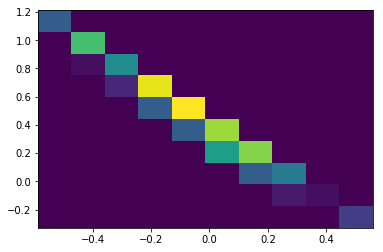

In [32]:
plt.hist2d(mock_ordered_abundances[:,1],mock_ordered_abundances[:,6]-mock_ordered_abundances[:,1]);
plt.contour()

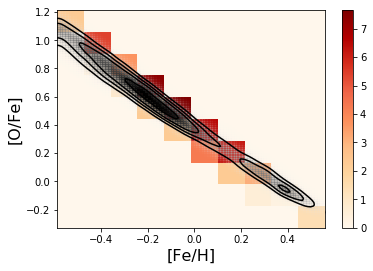

In [77]:
dat=np.load('/mnt/store1/oliverphilcox/ChempyMultiData/LC18_Abun/TNG_Mock_Data.npz')
all_abuns=dat.f.abundances
import matplotlib.pyplot as plt
fig=plt.figure()
ax=fig.gca()

xx=mock_ordered_abundances[:,1]
yy=(16.*mock_ordered_abundances[:,6]+24.*mock_ordered_abundances[:,3]+28.*mock_ordered_abundances[:,7])/(16.+28.+24.)-mock_ordered_abundances[:,1];
plt.hist2d(xx,yy,cmap=cm.OrRd,normed=True)

from corner import hist2d as cohist
x=all_abuns[:,1];y=(16.*all_abuns[:,6]+all_abuns[:,3]*24.+all_abuns[:,7]*28.)/(16.+24.+28.)-all_abuns[:,1]
cohist(x,y,bins=100,range=[[xx.min(),xx.max()],[yy.min(),yy.max()]],smooth=2.,alpha=0.5,no_fill_contours=True)

plt.ylabel(r'[$\alpha$/Fe]',fontsize=16)
plt.xlabel('[Fe/H]',fontsize=16)
plt.colorbar();#ax.colorbar()
#plt.show()

In [ ]:
#ax.hist2d(all_abuns[:,1],all_abuns[:,6]-all_abuns[:,1],bins=100,range=[[-1.2,0.55],[-0.3,2]],alpha=0.4);

x=all_abuns[:,1];y=all_abuns[:,6]-all_abuns[:,1]
from scipy.stats import kde
k = kde.gaussian_kde([x,y])
nbins=50
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
ax.contour(xi, yi, zi.reshape(xi.shape) )
